In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('{}{}(t-{})'.format(df.columns[0],j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('{}{}(t+{})'.format(df.columns[0],j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))

## feature/ target construction fucntion with lag variable
def feature_target_construct(df, load_lag, target_ahead, temp_ahead, wd_on = False):
    tempcols = ['temperature','temperature.1','temperature.2','temperature.3']
    load = df['TotalLoad']
    f_temp = pd.DataFrame()
    for col in tempcols:
        temp = lag_ahead_series(df[col], 
                             n_in = 0,
                             n_out = temp_ahead + 1,
                             n_vars = 1,
                             dropnan = True)
        f_temp = pd.concat([f_temp, temp], axis = 1)
    
    t = lag_ahead_series(load,
                          n_in = 0,
                          n_out = target_ahead + 1,
                          n_vars = 1,
                          dropnan = True)
                  
    if(target_ahead > temp_ahead):
        num_ahead = target_ahead
        f_temp = f_temp.iloc[load_lag:-num_ahead + temp_ahead,:]
        t = t.iloc[load_lag:,:]
    elif(target_ahead < temp_ahead):
        num_ahead = temp_ahead
        f_temp = f_temp.iloc[load_lag:,:]
        t = t.iloc[load_lag:-num_ahead + target_ahead,:]
    else:
        num_ahead = temp_ahead
        f_temp = f_temp.iloc[load_lag:,:]
        t = t.iloc[load_lag:,:]
        
    ## load lag series
    f_load = lag_ahead_series(load,
                          n_in = load_lag,
                          n_out = 0,
                          n_vars = 1,
                          dropnan = True).iloc[:-num_ahead,:]
    
    ## feature concatanation
    if wd_on:
        weekday = pd.get_dummies(df.iloc[load_lag:-num_ahead,-1])
        f = pd.concat([weekday, f_temp, f_load], axis = 1)
    else:
        f = pd.concat([f_temp, f_load], axis = 1)
    
    ## target load values
    
    
    return f, t
    

In [4]:
train = pd.read_csv("../data/train_elia.csv", index_col = 'time')
test = pd.read_csv("../data/test_elia.csv", index_col = 'time')

### Creat lag ahead scenarios

In [5]:
train_x ,train_y = feature_target_construct(train, 400, 96, 96, True)
test_x ,test_y = feature_target_construct(test, 400, 96, 96, True)

## Autosklearn

In [5]:
import autosklearn.regression as autoreg
from sklearn.model_selection import TimeSeriesSplit
y_pred = pd.DataFrame()
cls_list = []
cls = autoreg.AutoSklearnRegressor(time_left_for_this_task=410, 
                                       per_run_time_limit=200, 
                                       initial_configurations_via_metalearning=0,
                                       ensemble_size=50, 
                                       ensemble_nbest=25, 
                                       ensemble_memory_limit=1024, 
                                       seed=1, ml_memory_limit=4096, 
                                       include_estimators= None, 
                                       exclude_estimators=None, 
                                       include_preprocessors=None, 
                                       exclude_preprocessors=None, 
                                       resampling_strategy=TimeSeriesSplit, 
                                       resampling_strategy_arguments={'n_splits': 10}, 
                                       tmp_folder=None, 
                                       output_folder=None, 
                                       delete_tmp_folder_after_terminate=True, 
                                       delete_output_folder_after_terminate=True, 
                                       shared_mode=False, 
                                       n_jobs = 8, 
                                       disable_evaluator_output=False, 
                                       get_smac_object_callback=None, 
                                       smac_scenario_args=None, 
                                       logging_config=None, 
                                       metadata_directory=None)

cls.fit(train_x, train_y.iloc[:,48])



/home/charles/anaconda3/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


[WARNING] [2020-04-13 23:38:30,067:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-13 23:38:30,161:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-13 23:38:32,165:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-13 23:38:34,193:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-13 23:38:36,208:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-13 23:38:38,231:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-13 23:38:40,258:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than

Process Process-5:
Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/charles/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 1091, in fit
    load_models=load_models,
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/smbo.py", line 504, in ru

AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=0,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=4096, n_jobs=8, output_folder=None,
                     per_run_time_limit=200,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'n_splits': 10}, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task

In [63]:
y_pred = pd.DataFrame()

### refit using first 14000 data, for first 3 targets

In [6]:
for i in range(97):
    cls.refit(train_x.iloc[:-20000,:], train_y.iloc[:-20000,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

**Metrics**

In [8]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 97138.83400222956
MAE: 254.87936963058394
r2_score: 0.8578066247409512


**Visualization**

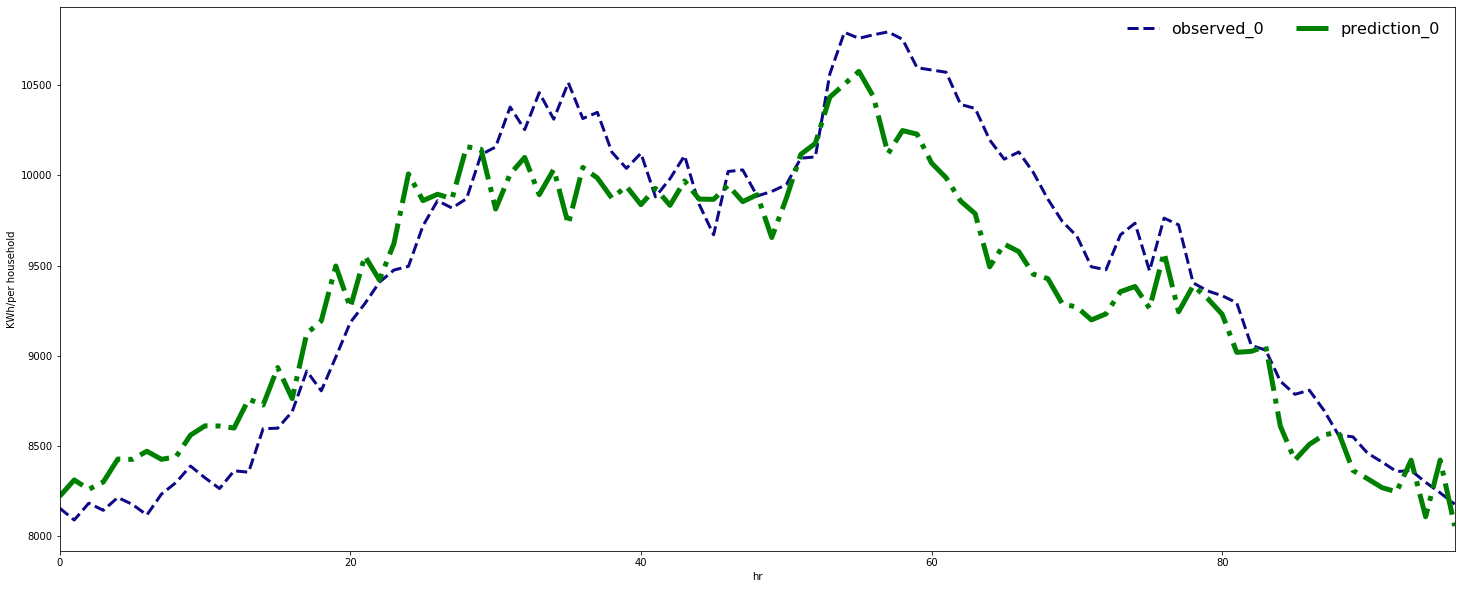

In [9]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

In [11]:
cls.get_models_with_weights()

[(0.92,
  SimpleRegressionPipeline({'categorical_encoding:__choice__': 'one_hot_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gradient_boosting', 'rescaling:__choice__': 'standardize', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'False', 'regressor:gradient_boosting:early_stop': 'valid', 'regressor:gradient_boosting:l2_regularization': 1.3341459944143704e-09, 'regressor:gradient_boosting:learning_rate': 0.22682054512816577, 'regressor:gradient_boosting:loss': 'least_squares', 'regressor:gradient_boosting:max_bins': 256, 'regressor:gradient_boosting:max_depth': 'None', 'regressor:gradient_boosting:max_iter': 245, 'regressor:gradient_boosting:max_leaf_nodes': 3, 'regressor:gradient_boosting:min_samples_leaf': 156, 'regressor:gradient_boosting:scoring': 'loss', 'regressor:gradient_boosting:tol': 1e-07, 'regressor:gradient_boosting:n_iter_no_change': 15, 'regressor:gradient_boosting:validation_fraction': 

In [30]:
cls.resampling_strategy

sklearn.model_selection._split.TimeSeriesSplit

### refit using first 7000 data

In [12]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[7000:,:], train_y.iloc[7000:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

**Metrics**

In [13]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 98019.15351698501
MAE: 252.30057969555392
r2_score: 0.8565179989879735


**Visualization**

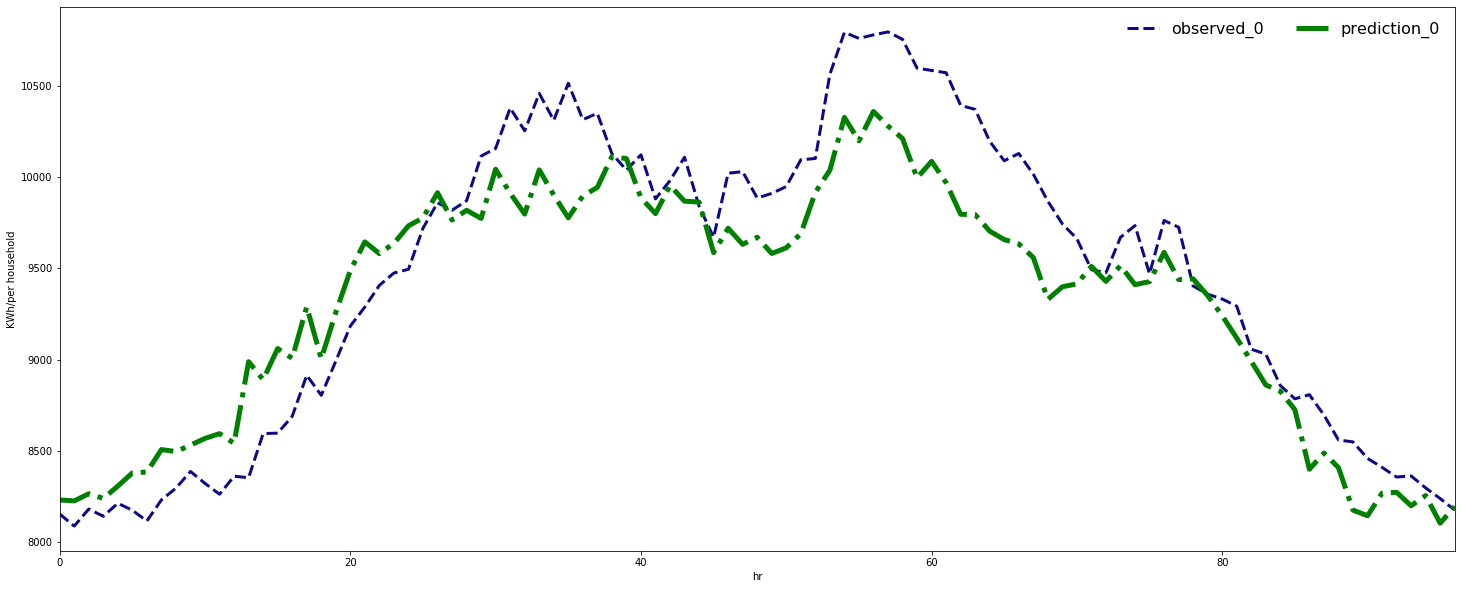

In [14]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### refit using first 3500 data

In [15]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[3500:,:], train_y.iloc[3500:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [18]:
observed = np.transpose(test_y[:1].to_numpy())
prediction = np.transpose(y_pred.iloc[:1,:].to_numpy())
get_eval(observed, prediction)

MSE: 89844.41890701684
MAE: 246.02929506282194
r2_score: 0.8689525707847442


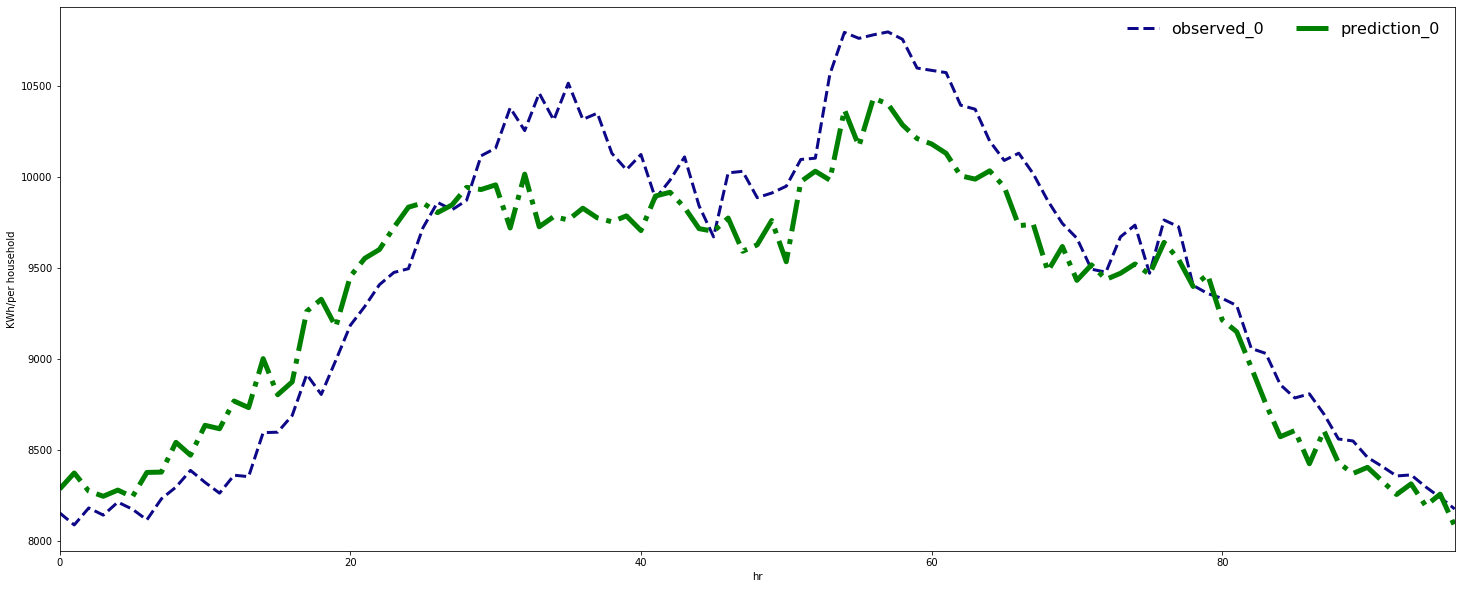

In [19]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

## longer time for searching

In [14]:
import autosklearn.regression as autoreg
from sklearn.model_selection import TimeSeriesSplit
y_pred = pd.DataFrame()
cls_list = []
cls = autoreg.AutoSklearnRegressor(time_left_for_this_task=610, 
                                       per_run_time_limit=280, 
                                       initial_configurations_via_metalearning=0,
                                       ensemble_size=50, 
                                       ensemble_nbest=25, 
                                       ensemble_memory_limit=1024, 
                                       seed=1, ml_memory_limit=4096, 
                                       include_estimators= None, 
                                       exclude_estimators=None, 
                                       include_preprocessors=None, 
                                       exclude_preprocessors=None, 
                                       resampling_strategy=TimeSeriesSplit, 
                                       resampling_strategy_arguments={'n_splits': 10}, 
                                       tmp_folder=None, 
                                       output_folder=None, 
                                       delete_tmp_folder_after_terminate=True, 
                                       delete_output_folder_after_terminate=True, 
                                       shared_mode=False, 
                                       n_jobs = 8, 
                                       disable_evaluator_output=False, 
                                       get_smac_object_callback=None, 
                                       smac_scenario_args=None, 
                                       logging_config=None, 
                                       metadata_directory=None)

cls.fit(train_x, train_y.iloc[:,48])



[WARNING] [2020-04-14 12:21:20,020:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:21:20,030:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:21:22,041:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:21:24,052:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:21:26,080:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:21:28,107:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:21:30,116:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than

[WARNING] [2020-04-14 12:23:11,015:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:23:13,034:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 12:23:15,044:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=0,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=4096, n_jobs=8, output_folder=None,
                     per_run_time_limit=280,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'n_splits': 10}, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task

In [9]:
cls.cv_results_

{'mean_test_score': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.43091735e-01,
         0.00000000e+00, -1.08589970e+02,  0.00000000e+00,  0.00000000e+00,
        -6.48223390e-01,  0.00000000e+00,  6.88351917e-01,  0.00000000e+00,
         1.00664676e-01, -1.08660986e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.16278787e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.93781718e-01,  9.50907415e-02,
         6.88557652e-01,  0.00000000e+00,  5.78691304e-01,  0.00000000e+00,
         1.78925119e-01,  0.00000000e+00,  0.00000000e+00,  6.27761030e-02,
         0.00000000e+00,  0.00000000e+00, -5.37494909e-02,  0.00000000e+00,
         0.00000000e+00]),
 'mean_fit_time': array([300.34497857,  11.89569592,  19.71919751,  18.39388919,
          9.68967056,  41.8376565 , 193.44203639, 300.38992095,
         34.89416099, 157.11301041,  63.36415505, 141.07261682,
         80.06486869,  33.87898731,  19.07488871, 273.1871814

### 14000

In [15]:
for i in range(97):
    cls.refit(train_x.iloc[:-20000,:], train_y.iloc[:-20000,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [16]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 110404.00217081058
MAE: 275.28313540324297
r2_score: 0.8383888599031918


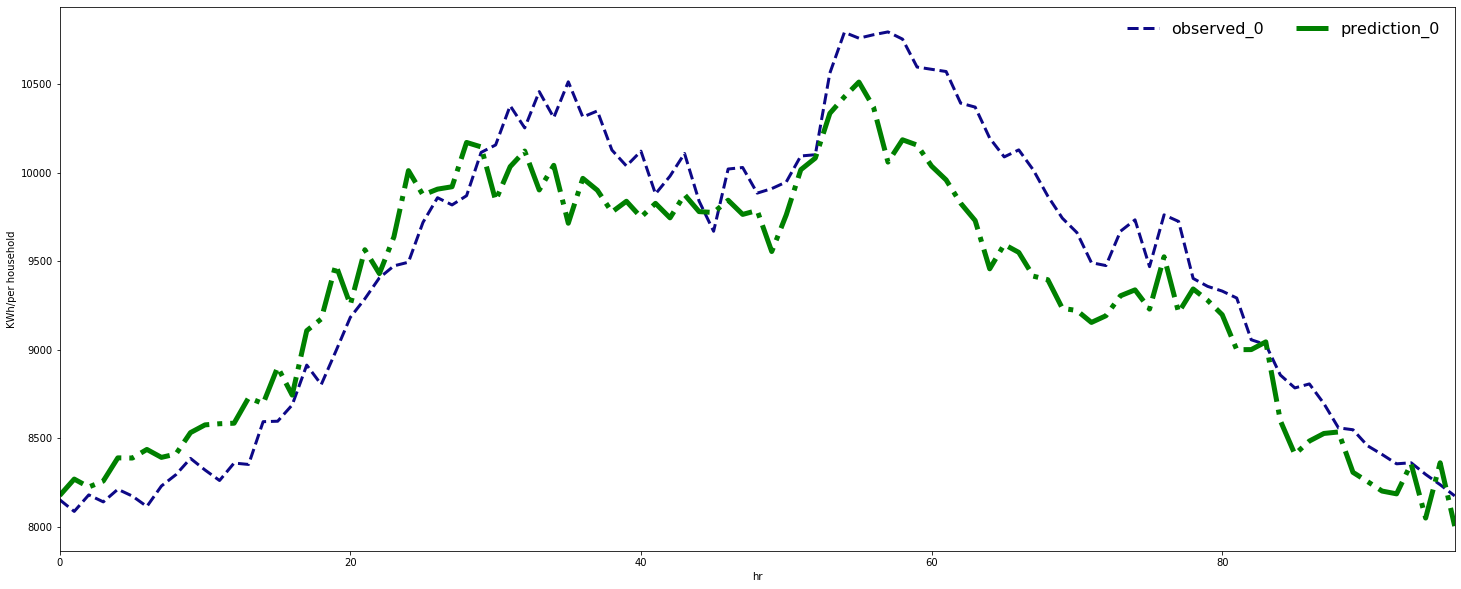

In [17]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### 7000

In [21]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[7000:,:], train_y.iloc[7000:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [22]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 102006.6084529411
MAE: 263.424165223636
r2_score: 0.8506810988248118


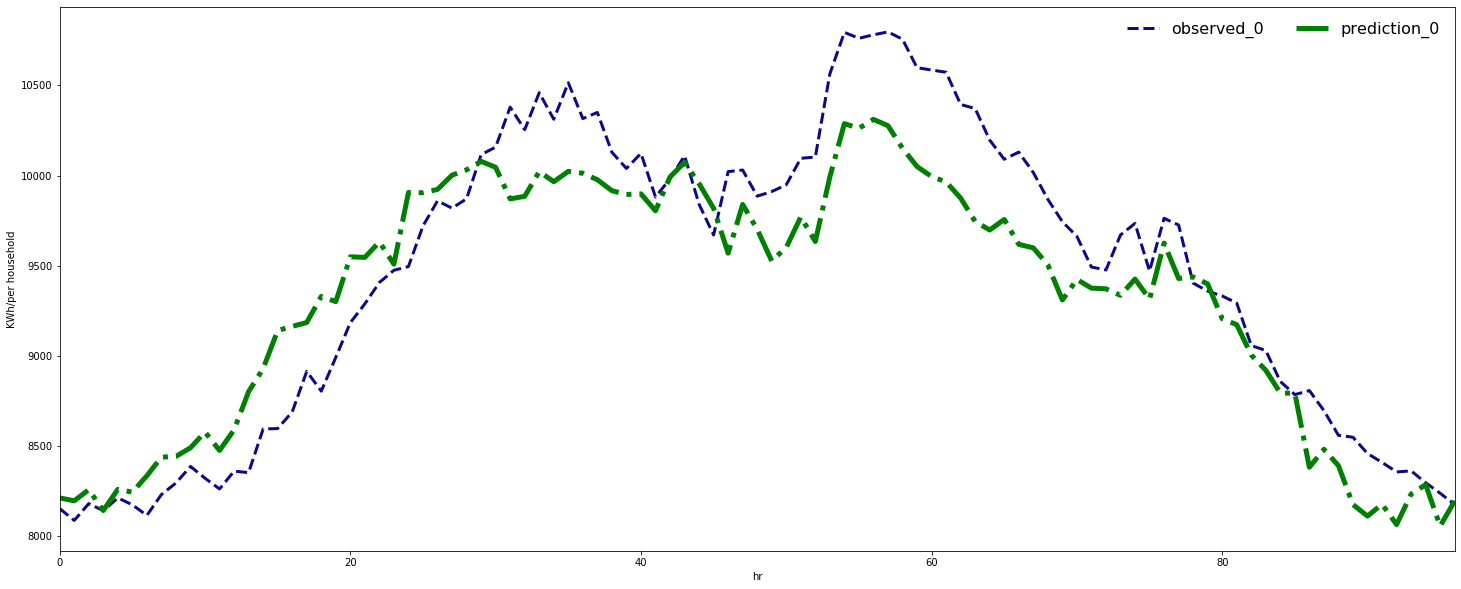

In [23]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### 3500

In [18]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[3500:,:], train_y.iloc[3500:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [19]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 96843.6909418269
MAE: 258.5578967327103
r2_score: 0.8582386598623729


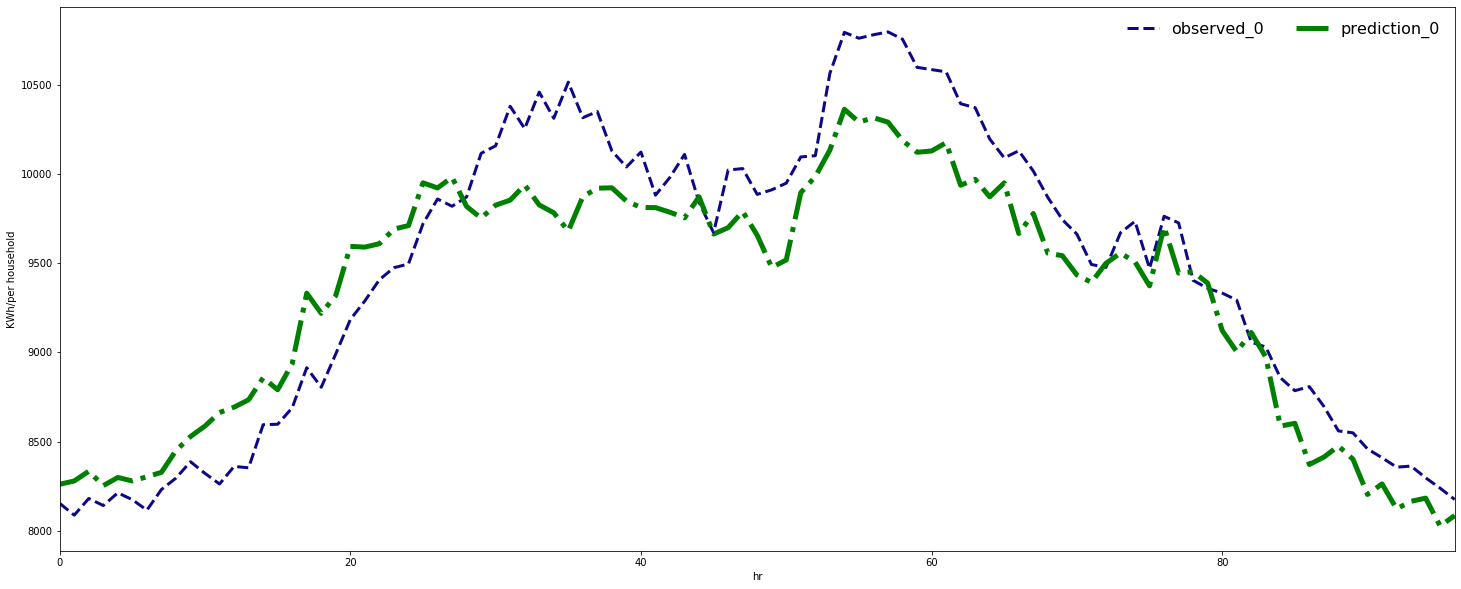

In [20]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

# different fit target for automl

In [17]:
import autosklearn.regression as autoreg
from sklearn.model_selection import TimeSeriesSplit
y_pred = pd.DataFrame()
cls_list = []
cls = autoreg.AutoSklearnRegressor(time_left_for_this_task=410, 
                                       per_run_time_limit=200, 
                                       initial_configurations_via_metalearning=0,
                                       ensemble_size=50, 
                                       ensemble_nbest=25, 
                                       ensemble_memory_limit=1024, 
                                       seed=1, ml_memory_limit=4096, 
                                       include_estimators= None, 
                                       exclude_estimators=None, 
                                       include_preprocessors=None, 
                                       exclude_preprocessors=None, 
                                       resampling_strategy=TimeSeriesSplit, 
                                       resampling_strategy_arguments={'n_splits': 10}, 
                                       tmp_folder=None, 
                                       output_folder=None, 
                                       delete_tmp_folder_after_terminate=True, 
                                       delete_output_folder_after_terminate=True, 
                                       shared_mode=False, 
                                       n_jobs = 8, 
                                       disable_evaluator_output=False, 
                                       get_smac_object_callback=None, 
                                       smac_scenario_args=None, 
                                       logging_config=None, 
                                       metadata_directory=None)

cls.fit(train_x, train_y.iloc[:,50])



[WARNING] [2020-04-14 18:51:13,430:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:51:13,456:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:51:15,462:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:51:17,469:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:51:19,475:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:51:21,480:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:51:23,488:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than

[WARNING] [2020-04-14 18:53:04,344:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:53:06,352:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:53:08,366:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:53:10,380:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:53:12,419:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:53:14,432:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than random - using Dummy Score!
[WARNING] [2020-04-14 18:53:16,444:EnsembleBuilder(1791095845):9c8e833eae10d74ba1cf8ef6d50e9a02] No models better than

AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=0,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=4096, n_jobs=8, output_folder=None,
                     per_run_time_limit=200,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'n_splits': 10}, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task

In [18]:
cls.get_models_with_weights()

[(0.64,
  SimpleRegressionPipeline({'categorical_encoding:__choice__': 'one_hot_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'nystroem_sampler', 'regressor:__choice__': 'ridge_regression', 'rescaling:__choice__': 'minmax', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'preprocessor:nystroem_sampler:kernel': 'sigmoid', 'preprocessor:nystroem_sampler:n_components': 486, 'regressor:ridge_regression:alpha': 0.00029210603380761555, 'regressor:ridge_regression:fit_intercept': 'True', 'regressor:ridge_regression:tol': 0.0009069197080121214, 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.08571308492963561, 'preprocessor:nystroem_sampler:coef0': 0.5884123023773058, 'preprocessor:nystroem_sampler:gamma': 0.00095514320016912},
  dataset_properties={
    'task': 4,
    'sparse': False,
    'multilabel': False,
    'multiclass': False,
    'target_type': 'regression',
    'signed': False})),
 (0.3,
  SimpleRegressionPipeline({'categorical

### 3500

In [ ]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[3500:,:], train_y.iloc[3500:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [ ]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

In [ ]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

# Fewer cv

In [7]:
cls.get_models_with_weights()

[(0.88,
  SimpleRegressionPipeline({'categorical_encoding:__choice__': 'no_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'random_trees_embedding', 'regressor:__choice__': 'liblinear_svr', 'rescaling:__choice__': 'robust_scaler', 'preprocessor:random_trees_embedding:bootstrap': 'True', 'preprocessor:random_trees_embedding:max_depth': 5, 'preprocessor:random_trees_embedding:max_leaf_nodes': 'None', 'preprocessor:random_trees_embedding:min_samples_leaf': 18, 'preprocessor:random_trees_embedding:min_samples_split': 15, 'preprocessor:random_trees_embedding:min_weight_fraction_leaf': 1.0, 'preprocessor:random_trees_embedding:n_estimators': 23, 'regressor:liblinear_svr:C': 6.4282285688712255, 'regressor:liblinear_svr:dual': 'False', 'regressor:liblinear_svr:epsilon': 0.010598352290921247, 'regressor:liblinear_svr:fit_intercept': 'True', 'regressor:liblinear_svr:intercept_scaling': 1, 'regressor:liblinear_svr:loss': 'squared_epsilon_insensitive', 'regressor:liblinear_svr

### 3500

In [8]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[3500:,:], train_y.iloc[3500:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [9]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 279249.5054213118
MAE: 414.66986905337194
r2_score: 0.5912301179735693


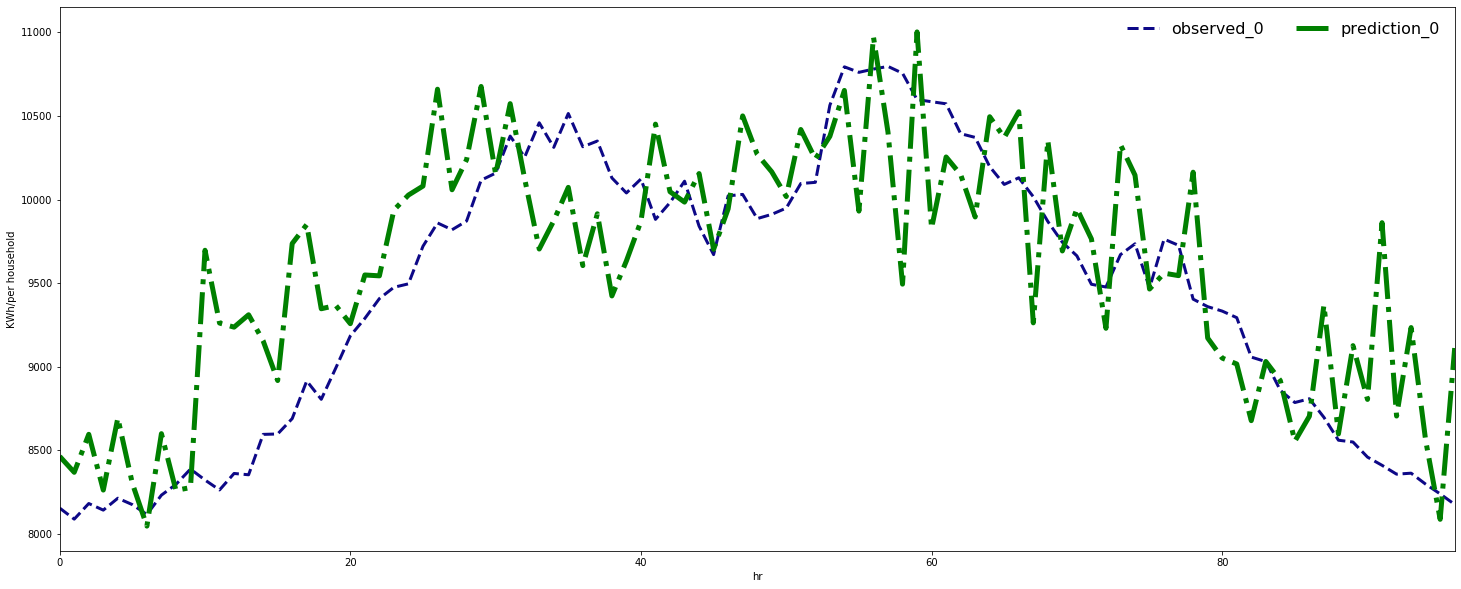

In [10]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### 7000

In [11]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[7000:,:], train_y.iloc[7000:,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [12]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 319196.31694798096
MAE: 465.36764517557987
r2_score: 0.5327553378286501


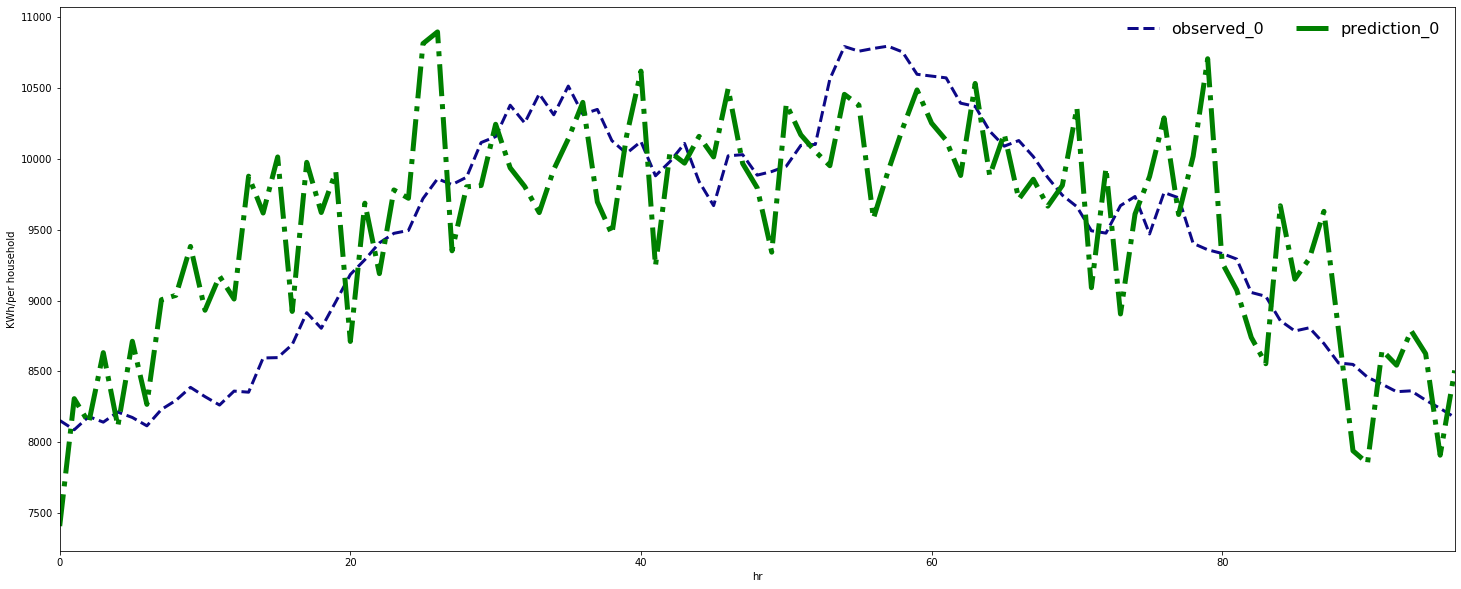

In [13]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### 14000

In [14]:
y_pred = pd.DataFrame()
for i in range(97):
    cls.refit(train_x.iloc[:-20000,:], train_y.iloc[:-20000,i])
    y_pred = pd.concat([y_pred, pd.DataFrame(cls.predict(test_x.iloc[:3,]))], axis = 1)

In [15]:
observed = np.transpose(test_y[:3].to_numpy())
prediction = np.transpose(y_pred.iloc[:3,:].to_numpy())
get_eval(observed, prediction)

MSE: 484000.6391095081
MAE: 550.4405068728521
r2_score: 0.29151214126228686


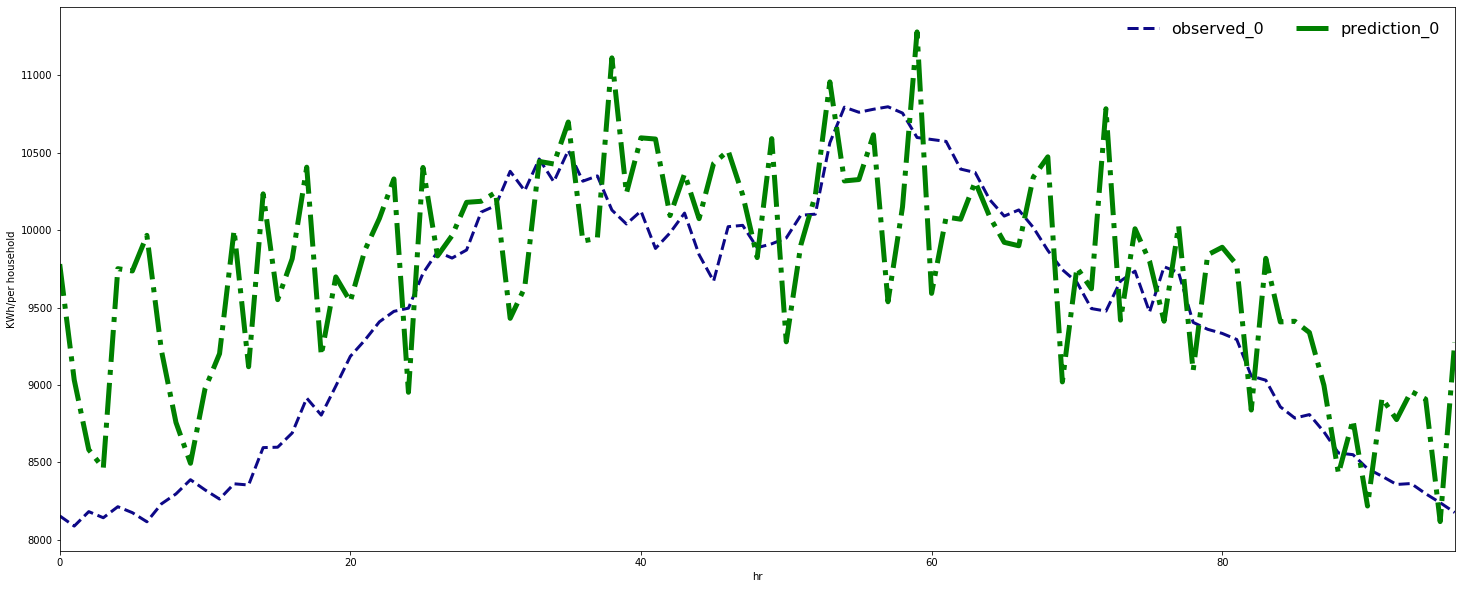

In [16]:
## assignment.
real = test_y[:1].to_numpy()
guess = y_pred.iloc[:1,:].to_numpy()

rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()

rpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw= 3)
gpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax, lw= 5)

ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()